# Установка SHAP
Импорт модулей

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.2 MB/s 


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as pl
import shap

# Загрузка данных

In [49]:
train_df = pd.read_csv('/content/drive/MyDrive/Stepic_ML/Stepic_contest/df/train_df.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Stepic_ML/Stepic_contest/df/test_df.csv')

# Создание X_train, y_train, X_test

In [50]:
X_train = train_df.drop(['passed_course', 'unique_wrong'], axis=1)
y_train = train_df['passed_course']
X_test = test_df.drop(['unique_wrong'], axis=1)
test_user_id = test_df['user_id']

In [51]:
X_test.columns

Index(['user_id', 'discovered', 'passed', 'started_attempt', 'viewed',
       'sum_event_action', 'sum_unique_event_action', 'event_unique_periods',
       'unique_viewed', 'unique_passed', 'unique_discovered',
       'unique_started_attempt', 'event_timestamp_diff', 'days', 'round_days',
       'correct', 'wrong', 'sum_submission_action',
       'sum_unique_submission_action', 'submission_unique_periods',
       'unique_correct', 'submission_timestamp_diff', 'sum(correct+wrong)',
       'ratio(passed/started_attempt)',
       'ratio(unique_passed/unique_started_attempt)',
       'ratio(unique_correct/unique_started_attempt)',
       'ratio(correct/started_attempt)',
       'ratio(sum(correct+wrong)/started_attempt)',
       'ratio(correct/sum(correct+wrong)',
       'ratio(correct/sum_submission_action',
       'ratio(unique_correct/sum_unique_submission_action',
       'ratio(event_timestamp_diff/event_unique_periods)',
       'ratio(submission_timestamp_diff/submission_unique_period

In [52]:
X_test.describe()

,user_id,discovered,passed,started_attempt,viewed,sum_event_action,sum_unique_event_action,event_unique_periods,unique_viewed,unique_passed,...,ratio(sum(correct+wrong)/started_attempt),ratio(correct/sum(correct+wrong),ratio(correct/sum_submission_action,ratio(unique_correct/sum_unique_submission_action,ratio(event_timestamp_diff/event_unique_periods),ratio(submission_timestamp_diff/submission_unique_periods),ratio(submission_timestamp_diff/event_timestamp_diff),ratio(correct/submission_timestamp_diff),ratio(correct/submission_unique_periods),first_timestamp_diff
count,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,...,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6.184000e+03
mean,13471.482050,10.877749,10.083603,4.344599,19.126132,44.432083,10.920763,6.885511,10.877749,10.083603,...,0.607856,0.324569,0.324569,0.434160,3469.039612,1724.813692,15.853323,0.007460,0.636118,-8.405639e+08
std,7698.056738,17.601541,16.496344,9.096022,41.319291,81.401342,17.624441,13.774054,17.601541,16.496344,...,2.944287,0.402602,0.402602,0.487353,9632.610263,5316.731470,369.799461,0.024423,0.839559,7.657553e+08
min,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.547871e+09
25%,6884.500000,1.000000,1.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.539155e+09
50%,13516.500000,2.000000,2.000000,1.000000,3.000000,7.000000,2.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,41.500000,0.000000,0.000000,0.000000,0.000000,-1.528388e+09
75%,20138.500000,12.000000,11.000000,4.000000,17.000000,44.000000,12.000000,4.000000,12.000000,11.000000,...,1.000000,0.666667,0.666667,1.000000,1750.948660,254.375000,0.205192,0.000632,1.142857,9.300000e+01
max,26800.000000,180.000000,151.000000,113.000000,543.000000,839.000000,180.000000,136.000000,180.000000,151.000000,...,166.000000,1.000000,1.000000,1.000000,85532.000000,86362.000000,18305.444444,0.666667,13.333333,1.629952e+07


# Train_test_split

In [53]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, 
                                                      test_size=0.1, random_state=0,
                                                      stratify=y_train)

In [54]:
clm = list(X_val.columns)

# Random_forest_baseline

In [55]:
rnf_baseline = RandomForestClassifier(n_estimators=102,
                                      max_depth=10, 
                                      random_state=0,
                                      min_samples_leaf=4,
                                      #criterion='entropy',
                                      #class_weight='balanced_subsample'
                                      )

In [56]:
rnf_baseline.fit(X_train_, y_train_)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=102,
                       random_state=0)

# Метрики rnf_baseline

In [57]:
rnf_baseline.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 102,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

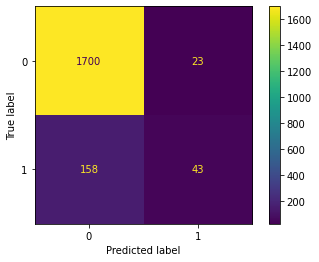

In [58]:
cmd = confusion_matrix(y_val, pd.DataFrame(rnf_baseline.predict(X_val)).replace({'False': ''}).astype(bool))
ConfusionMatrixDisplay(cmd).plot()

In [59]:
f1_score(y_val, pd.DataFrame(rnf_baseline.predict(X_val)).replace({'False': ''}).astype(bool))

0.32209737827715357

In [60]:
rnf_baseline.score(X_val, y_val)

0.9059251559251559

In [61]:
auc = roc_auc_score(y_val, rnf_baseline.predict_proba(X_val)[:,1])
auc

0.8939718124409871

In [62]:
best_clf = rnf_baseline

# Поиск параметров CV

In [ ]:
rnf_cv = RandomForestClassifier()

In [ ]:
cv_params = {'n_estimators': range(90, 110), 
            'max_depth': range(8, 13),
            'min_samples_leaf': range(1,6),
            'criterion':['gini', 'entropy']}

In [ ]:
rscv = RandomizedSearchCV(rnf_cv, param_distributions=cv_params,
                          cv=5,
                          n_iter=100,
                          n_jobs=-1,
                          scoring='roc_auc')
rscv.fit(X_train, y_train)
print(f"Наилучшие параметры: {rscv.best_params_}")
ypred_prob = rscv.predict_proba(X_val)
    
roc_score = roc_auc_score(y_val, ypred_prob[:, 1])
score = rscv.score(X_val, y_val)
print(f"Правильность на тестовом наборе: {score:.2f}")
print(roc_score)

KeyboardInterrupt: ignored

# SHAP

In [63]:
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_val)

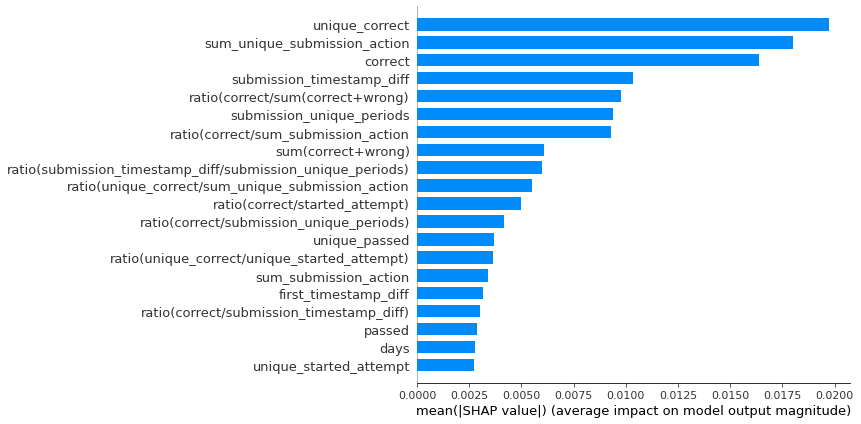

In [64]:
shap.summary_plot(shap_values[1], X_val, plot_type="bar", plot_size=(12,6))

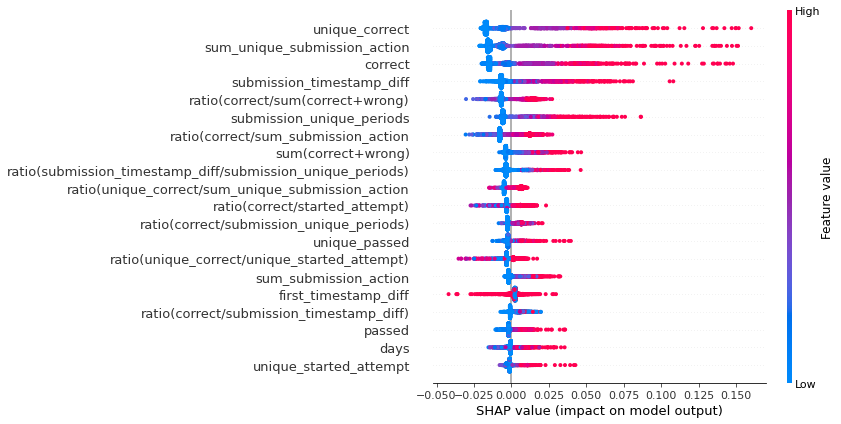

In [65]:
shap.summary_plot(shap_values[1], X_val, plot_size=(12,6))

In [66]:
clm

['user_id',
 'discovered',
 'passed',
 'started_attempt',
 'viewed',
 'sum_event_action',
 'sum_unique_event_action',
 'event_unique_periods',
 'unique_viewed',
 'unique_passed',
 'unique_discovered',
 'unique_started_attempt',
 'event_timestamp_diff',
 'days',
 'round_days',
 'correct',
 'wrong',
 'sum_submission_action',
 'sum_unique_submission_action',
 'submission_unique_periods',
 'unique_correct',
 'submission_timestamp_diff',
 'sum(correct+wrong)',
 'ratio(passed/started_attempt)',
 'ratio(unique_passed/unique_started_attempt)',
 'ratio(unique_correct/unique_started_attempt)',
 'ratio(correct/started_attempt)',
 'ratio(sum(correct+wrong)/started_attempt)',
 'ratio(correct/sum(correct+wrong)',
 'ratio(correct/sum_submission_action',
 'ratio(unique_correct/sum_unique_submission_action',
 'ratio(event_timestamp_diff/event_unique_periods)',
 'ratio(submission_timestamp_diff/submission_unique_periods)',
 'ratio(submission_timestamp_diff/event_timestamp_diff)',
 'ratio(correct/submiss

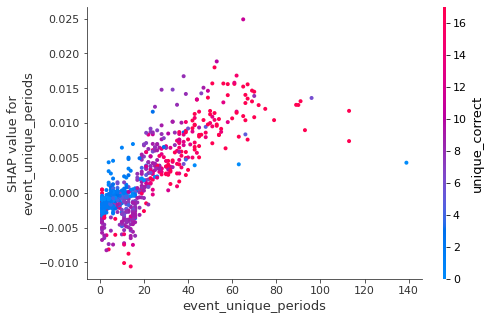

In [ ]:
shap.dependence_plot(clm[7], shap_values[1], X_val, show=True, 
                     #interaction_index='correct'
                     )

# Предсказание X_test

In [44]:
predict = best_clf.predict_proba(X_test)[:,1]

In [45]:
result = pd.DataFrame(test_user_id)
result['is_gone'] = predict

In [46]:
pd.DataFrame(best_clf.predict(X_test)).value_counts()

False    5978
True      206
dtype: int64

In [47]:
result

,user_id,is_gone
0,4,0.000000
1,6,0.000000
2,10,0.000000
3,12,0.098025
4,13,0.702992
...,...,...
6179,26791,0.000000
6180,26795,0.000000
6181,26796,0.061319
6182,26799,0.098208


In [48]:
path = f'/content/drive/MyDrive/Stepic_ML/Stepic_contest/{auc:.5f}rf_result.csv'
with open(path, 'w+', encoding = 'utf-8-sig') as f:
    result.to_csv(f, index=False)